캐글 신용카드 사기 검출 분류
 - 0: 정상적인 트랜잭션, 1: 사기 트랜잭션
 - 0.172%만이 사기 트랜잭션 -> 레이블 불균형
 - 적은 레이블에 대한 오버 샘플링 실행 (대표 방법: SMOTE)
  - 적은 레이블을 가진 데이터 세트를 증식

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/machine_learning_data/CredictCard/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

from sklearn.model_selection import train_test_split
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된(Time 칼럼 삭제된) 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)

    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]

    # train_test_split()으로 학습과 테스트 데이터 분할
    # stratify=y_traget: 데이터 분할시, 비율 유지
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size=0.3, random_state=0, 
                                                        stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [3]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0])
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0])

학습 데이터 레이블 값 비율
0    0.998275
1    0.001725
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    0.998268
1    0.001732
Name: Class, dtype: float64


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix
def get_clf_eval(y_test, pred, pred_proba):
    # 오차행렬: [[TN, FP], [FN, TP]]
    confusion = confusion_matrix(y_test, pred)
    # 정확도: (TP + TN) / (TP + TN + FP + FN)
    accuracy = accuracy_score(y_test, pred)
    # 정밀도: TP / (FP + TP)
    precision = precision_score(y_test, pred)
    # 재현률: TP / (FN + TP)
    recall = recall_score(y_test, pred)
    # F1
    f1 = f1_score(y_test, pred)
    # AUC
    roc_score = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0: .4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {0:.4f}'.format(accuracy, precision, recall, f1, roc_score))


In [5]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   56    92]]
정확도 :  0.9992, 정밀도: 0.8679, 재현율: 0.6216, F1: 0.7244, AUC: 0.9992


In [6]:
# 코드 단축을 위해 모델 학습/예측/평가 함수 생성

# 인자로 사이킷런의 Estimator객체와 학습/테스트 데이터 세트를 입력 받아
# 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [7]:
# LightGBM 학습시, 레이블 값이 극도로 불균형하기 때문에
# boost_from_average = False 설정
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leavs=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85291     4]
 [   36   112]]
정확도 :  0.9995, 정밀도: 0.9655, 재현율: 0.7568, F1: 0.8485, AUC: 0.9995


### 데이터 분포도 변환 후 모델 학습/예측/평가

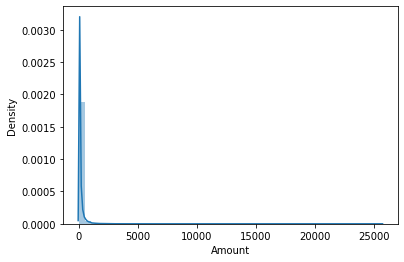

In [14]:
# Amount 피처는 중요한 데이터 일 가능성이 큼
# 선형회귀의 경우 중요 피처들의 값이 정규 분포 형태를 유지하는 것이 좋음

import seaborn as sns
sns.distplot(card_df['Amount'])
plt.show()

# 긴 꼬리 분포를 가지고 있음 -> 정규 분포 형태로 변환

In [39]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용하여, 정규 부포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))

    # 변환된 Amount를 Amount_Scaled 피처명으로 변경후 DataFrame 맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)

    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [41]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leavs=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

# 성능 개선이 크지 않음

로지스틱 회귀 예측 성능
오차 행렬
[[85281    14]
 [   58    90]]
정확도 :  0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9992
LightGBM 예측 성능
오차 행렬
[[85291     4]
 [   36   112]]
정확도 :  0.9995, 정밀도: 0.9655, 재현율: 0.7568, F1: 0.8485, AUC: 0.9995


In [42]:
# 로그 변환을 통해, 데이터 분포가 심하게 왜곡되어 있는 것을 완화

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용하여 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [43]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('로지스틱 회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leavs=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

# 약간의 성능 향상

로지스틱 회귀 예측 성능
오차 행렬
[[85283    12]
 [   59    89]]
정확도 :  0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9992
LightGBM 예측 성능
오차 행렬
[[85291     4]
 [   35   113]]
정확도 :  0.9995, 정밀도: 0.9658, 재현율: 0.7635, F1: 0.8528, AUC: 0.9995


### 이상치 데이터 제거 후 모델 학습/예측/평가